In [1]:
library(igraph)
library(spectralGraphTopology)
library(sparseGraph)
library(matrixStats)
library(latex2exp)
library(scales)
set.seed(42)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘spectralGraphTopology’


The following object is masked from ‘package:stats’:

    D


Warning message:
“package ‘scales’ was built under R version 3.6.2”


In [2]:
# number of nodes
p <- 50
# generate a grid graph
ba_game <- sample_pa(n = p, m = 1, directed = FALSE, zero.appeal = 1e-1)
# Randomly assign weights to the edges
E(ba_game)$weight <- runif(gsize(ba_game), min = 2, max = 5)
# Get the true Laplacian matrices
Ltrue <- as.matrix(laplacian_matrix(ba_game))

In [3]:
la_true <- layout_nicely(ba_game)
V(ba_game)$color = "#81ecec"
E(ba_game)$color = "#576574"

In [4]:
gr = .5 * (1 + sqrt(5))

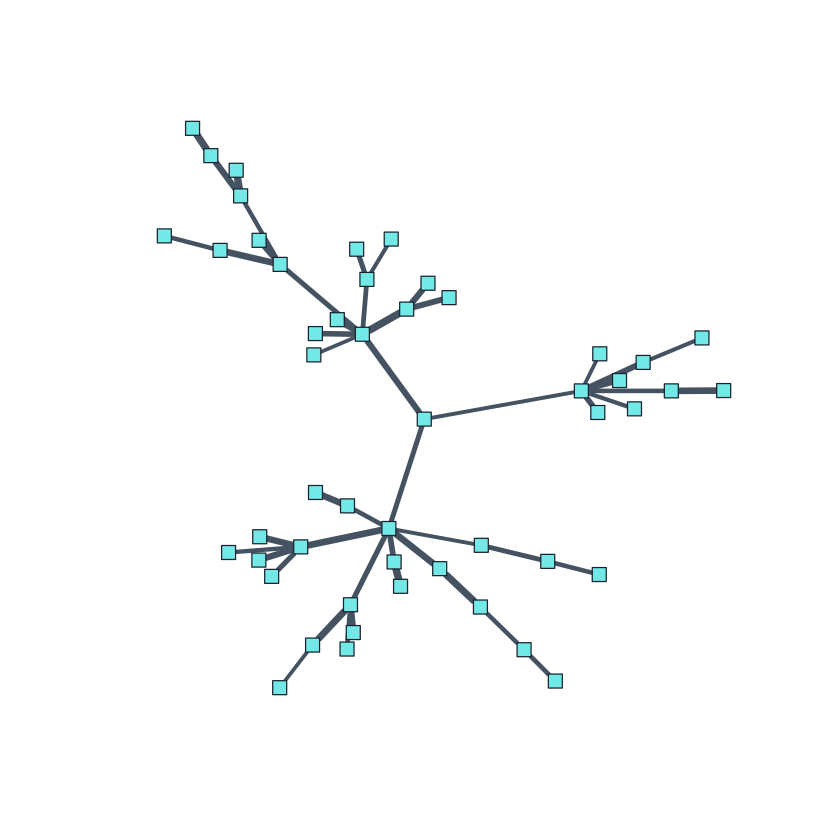

In [5]:
plot(ba_game, layout = la_true, vertex.frame.color = "#222f3e",
     vertex.label = NA, vertex.size = 5, vertex.label.color = "#34495e",
     vertex.shape = 'square', edge.width=(1 + E(ba_game)$weight))

In [6]:
library(ggplot2)

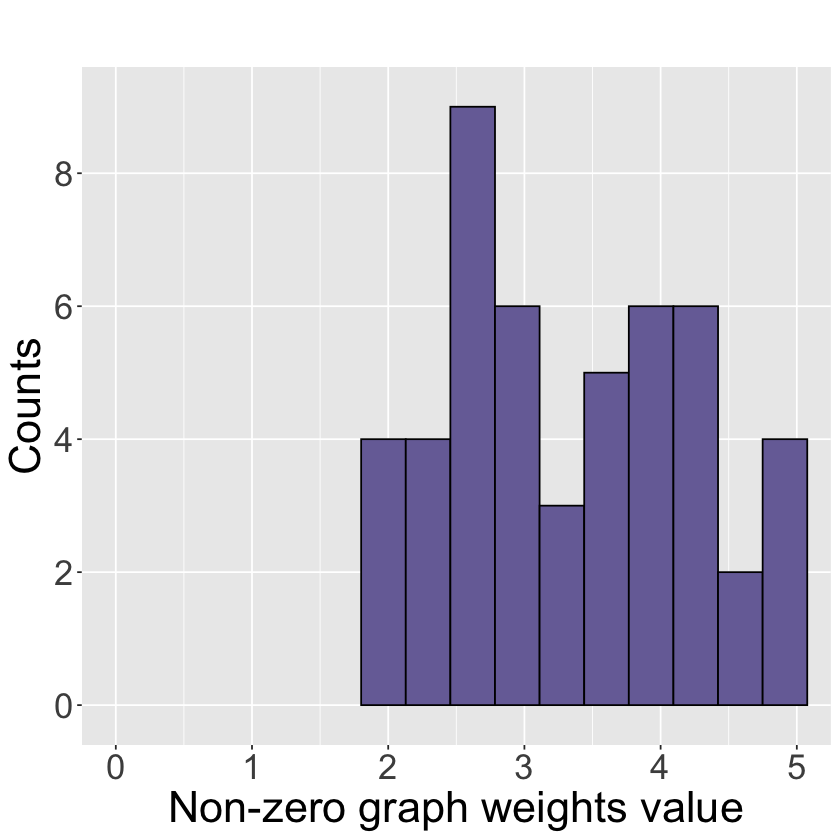

In [7]:
df <- data.frame(weight=E(ba_game)$weight)
#setEPS()
#cairo_ps("true-graph-hist.ps", family = "Palatino", height = 5, width = gr * 3.5,
#         pointsize = 28, fallback_resolution = 1400)
ggplot(df, aes(x=weight)) + coord_cartesian(xlim = c(0, 5), ylim = c(0, 9)) + # xlim(0, 5) +
 geom_histogram(colour="black", fill="#786fa6", bins=10) + 
 ggtitle("") + xlab("Non-zero graph weights value") + ylab("Counts") +
 theme(text = element_text(size=26)) + scale_y_discrete(name = "Counts", limits = c(seq(from=0, to=8, by=2)))
#dev.off()

# Sample results

In [8]:
X <- MASS::mvrnorm(6*p, mu = rep(0, p), Sigma = MASS::ginv(Ltrue))
# Compute the sample covariance matrix
S <- cov(X)

[1] "F-score and Relative Error:"
[1] 0.5326087 0.1363060


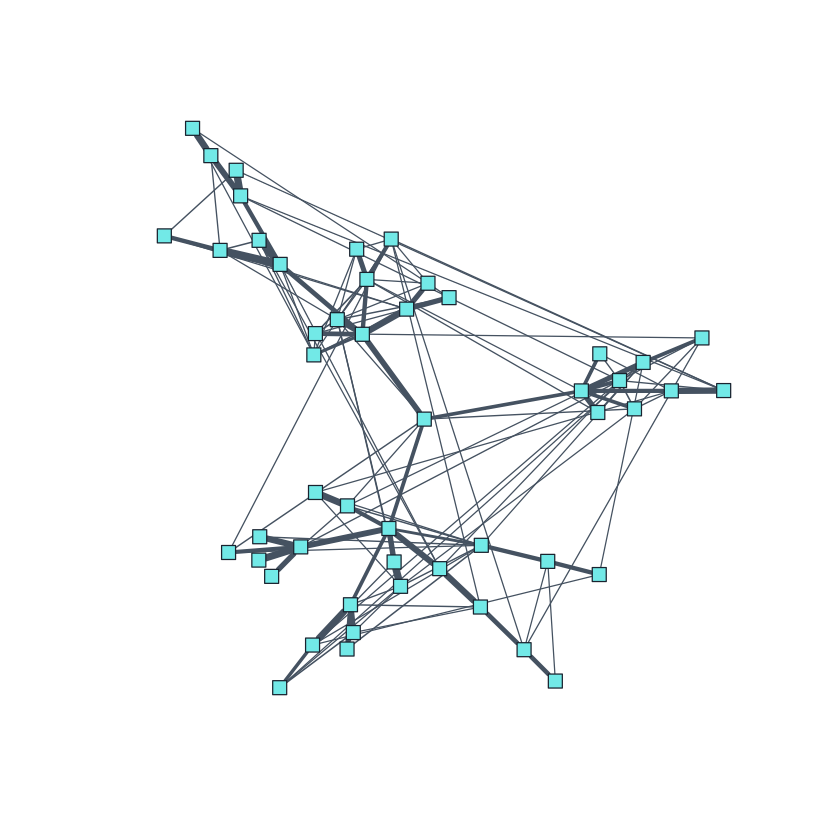

[1] "F-score and Relative Error:"
[1] 0.5185185 0.1429484


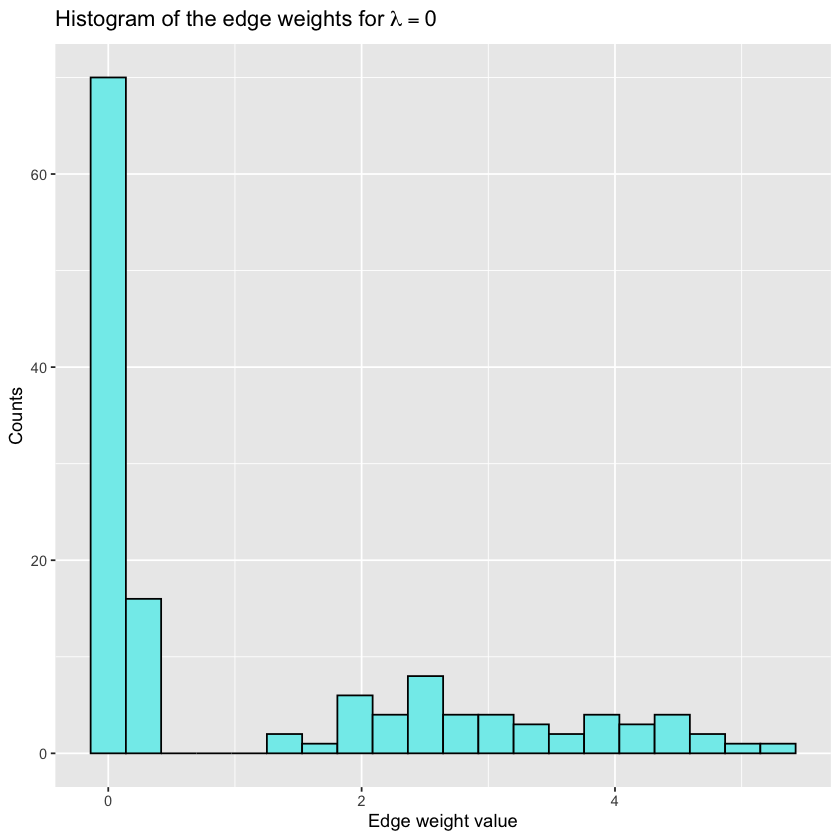

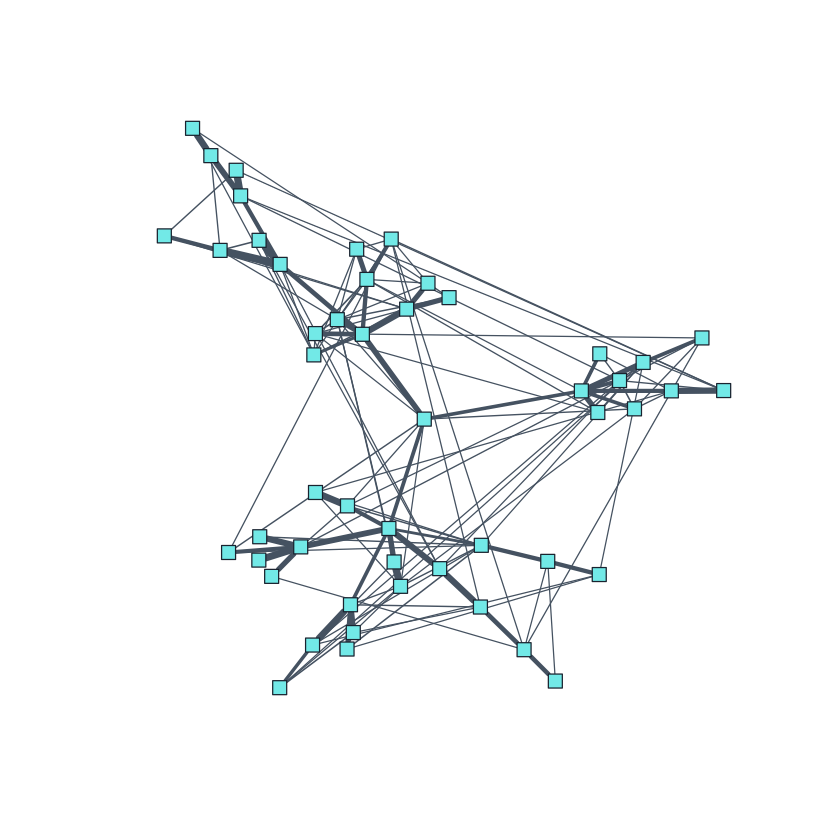

[1] "F-score and Relative Error:"
[1] 0.2925373 0.6429075


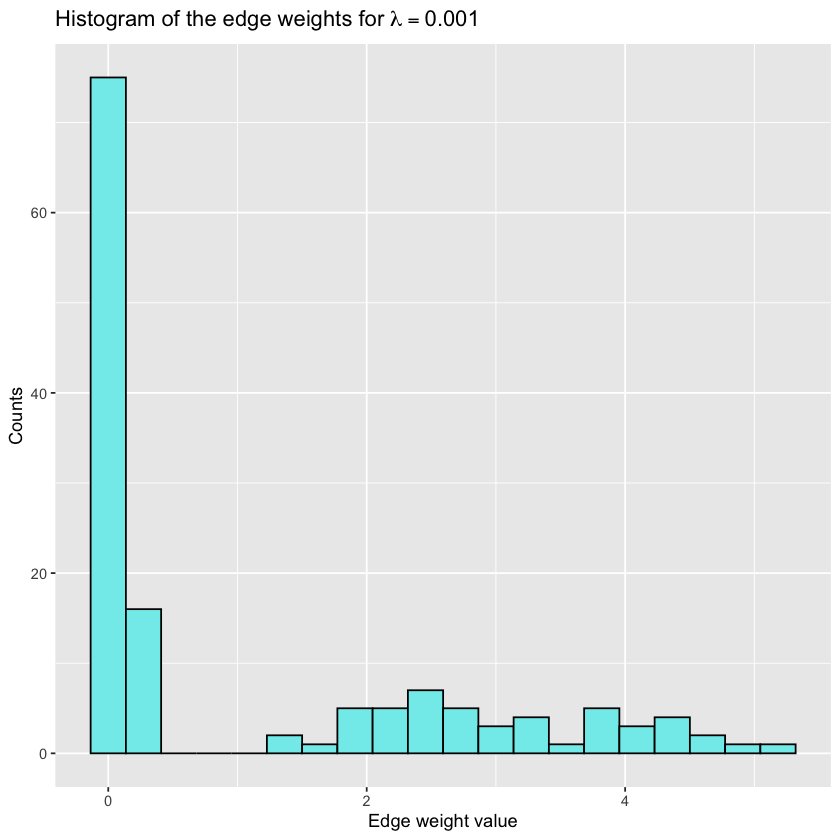

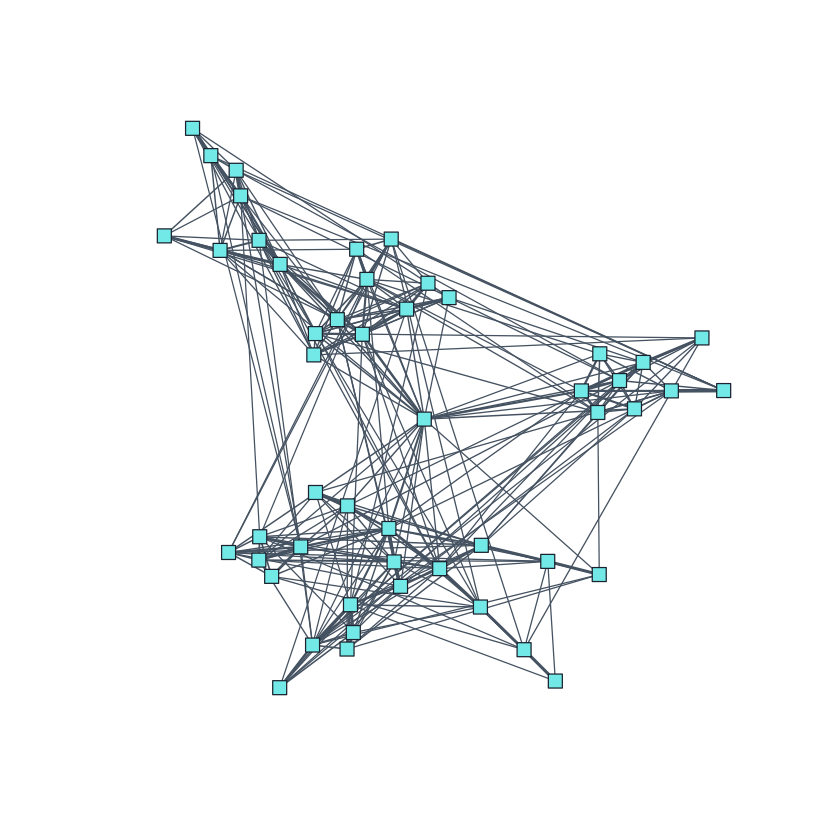

[1] "F-score and Relative Error:"
[1] 0.07692308 0.99318528


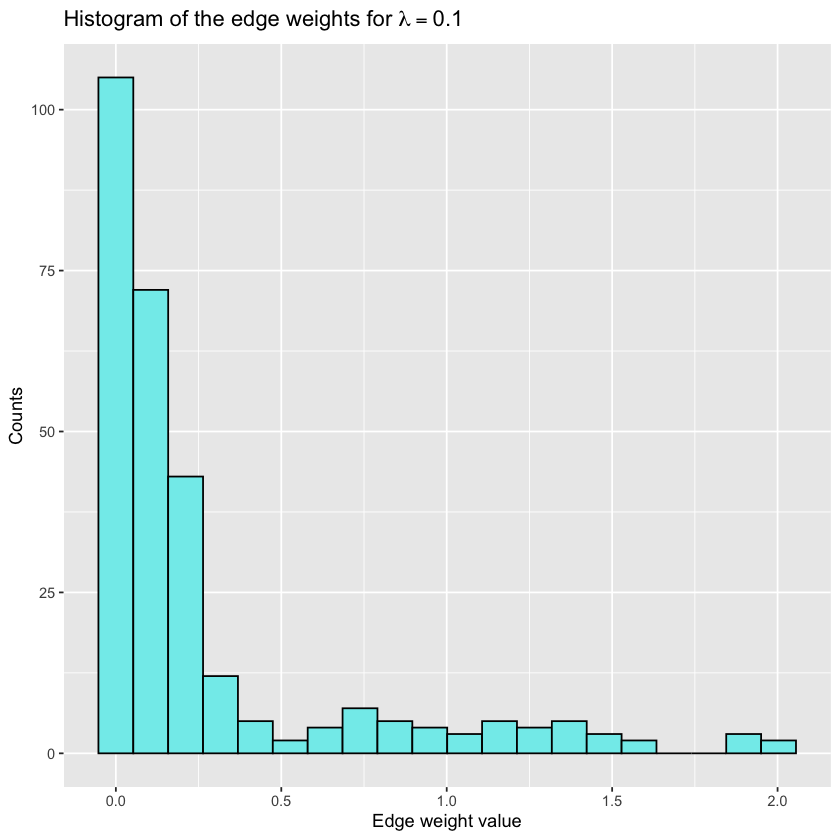

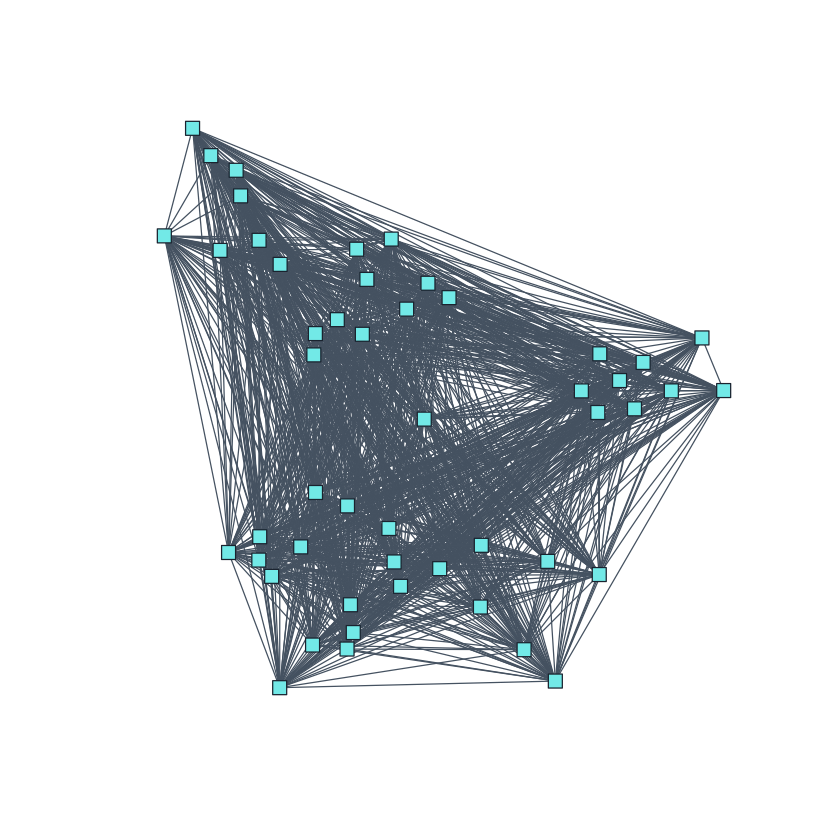

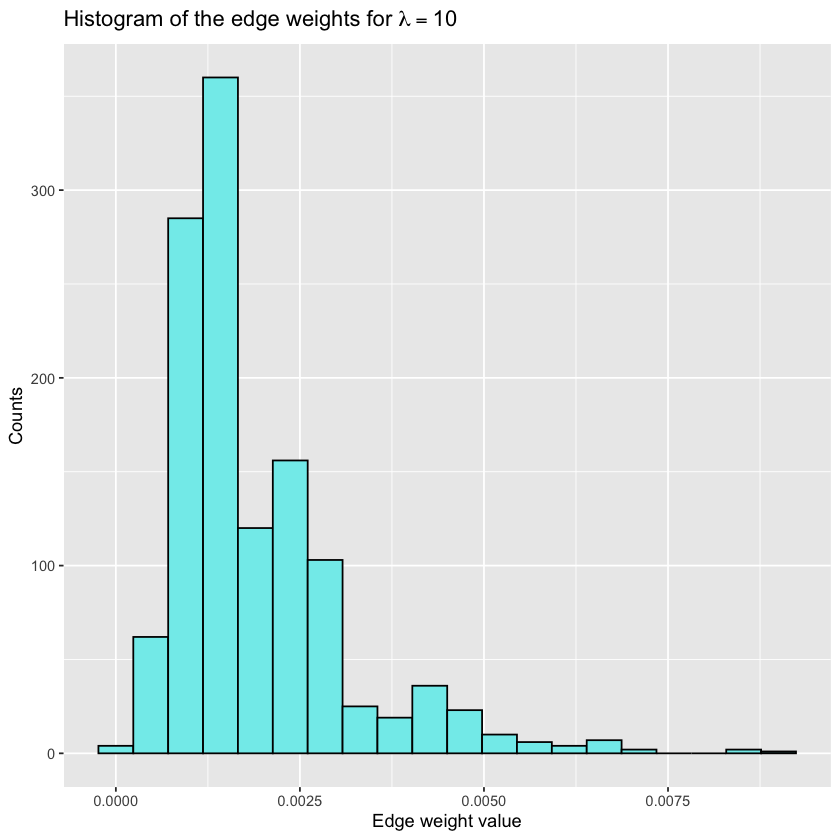

In [10]:
for (alpha in c(0, 1e-3, 1e-1, 10)) {
    graph_admm <- learn_laplacian_gle_admm(S = S, alpha = alpha, reltol = 1e-7, verbose = FALSE)
    print("F-score and Relative Error:")
    print(c(fscore(graph_admm$Laplacian, Ltrue, 1e-5), relative_error(graph_admm$Laplacian, Ltrue)))
    Adj <- graph_admm$Adjacency
    Adj[Adj < 1e-5] <- 0
    ba_game_admm <- graph_from_adjacency_matrix(adjmatrix = Adj, mode = "undirected", weighted = TRUE)
    V(ba_game_admm)$color = "#81ecec"
    E(ba_game_admm)$color = "#576574" 
    #setEPS()
    #postscript(paste0("tree-admm", alpha, ".ps"), family = "Times", height = 5, width = gr * 3.5)
    plot(ba_game_admm, layout = la_true, vertex.frame.color = "#222f3e",
         vertex.label = NA, vertex.size = 5, vertex.shape = 'square',
         edge.width=(1 + E(ba_game_admm)$weight))
    #dev.off()
    df <- data.frame(weight=E(ba_game_admm)$weight)
    #setEPS()
    #cairo_ps(paste0("tree-admm-hist", alpha, ".ps"), family = "Palatino", height = 5,
    #         width = gr * 3.5, pointsize = 14, fallback_resolution = 1400)
    g <- ggplot(df, aes(x=weight)) +
         geom_histogram(colour="black", fill="#81ecec", bins=20) +
         ggtitle(TeX(paste0("Histogram of the edge weights for ", "$\\lambda = ", alpha, "$"))) +
         xlab("Edge weight value") + ylab("Counts")
    print(g)
    #dev.off()
}

In [11]:
graph_mcp <- learn_laplacian_pgd_connected(S = S, alpha = 5e-1, gamma = 1.01,
                                           sparsity_type = "mcp", verbose = FALSE)

In [13]:
c(fscore(graph_mcp$laplacian, Ltrue, 1e-5), relative_error(graph_mcp$laplacian, Ltrue))

[1] 1.00000000 0.08121015

In [14]:
Adj <- graph_mcp$adjacency
ba_game_proposed <- graph_from_adjacency_matrix(adjmatrix = Adj,
                                                mode = "undirected", weighted = TRUE)
V(ba_game_proposed)$color = "#81ecec"
E(ba_game_proposed)$color = "#576574"

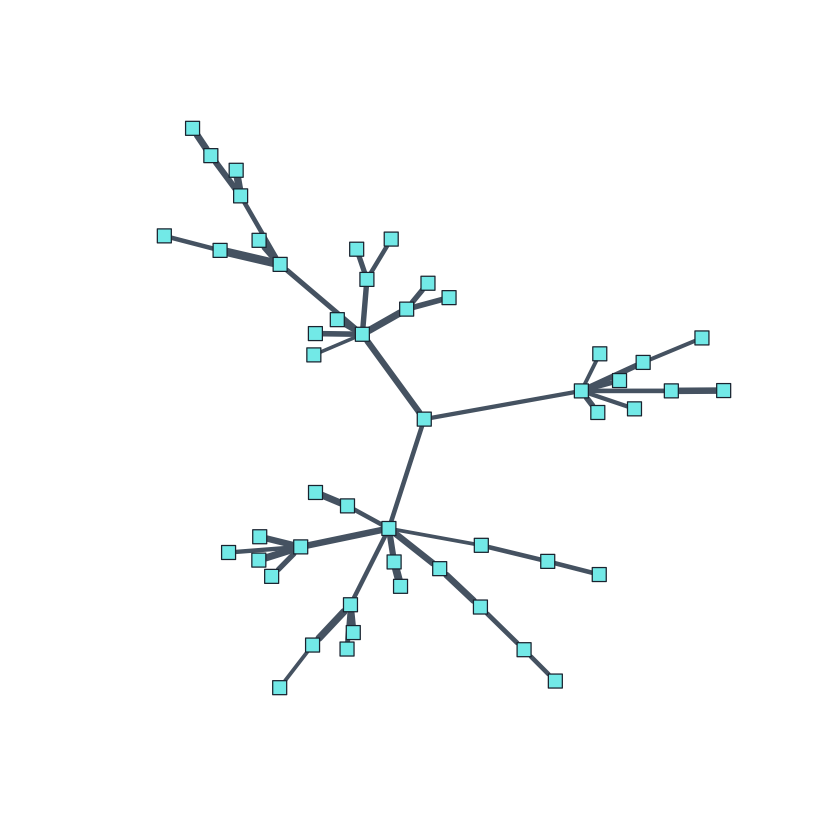

In [15]:
#setEPS()
#postscript("tree-mcp-05.ps", family = "Times", height = 5, width = gr * 3.5)
plot(ba_game_proposed, layout = la_true, vertex.frame.color = "#222f3e",
     vertex.label = NA, vertex.size = 5, vertex.label.color = "#34495e",
     vertex.shape = 'square', edge.width=(1 + E(ba_game_proposed)$weight))
#dev.off()

# Monte Carlo results

In [16]:
n_edges <- .5 * sum(Ltrue < 0)

In [17]:
alpha_swp <- c(0, 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2, 2.5e-2, 1e-1, 2.5e-1)

In [18]:
n_alphas <- c(1:length(alpha_swp))

In [20]:
n_realizations <- 100
nonzero_edges_admm <- matrix(0, length(alpha_swp), n_realizations)
re_admm <- matrix(0, length(alpha_swp), n_realizations)
fs_admm <- matrix(0, length(alpha_swp), n_realizations)
nonzero_edges_pgd <- matrix(0, length(alpha_swp), n_realizations)
re_pgd <- matrix(0, length(alpha_swp), n_realizations)
fs_pgd <- matrix(0, length(alpha_swp), n_realizations)
nonzero_edges_scad <- matrix(0, length(alpha_swp), n_realizations)
re_scad <- matrix(0, length(alpha_swp), n_realizations)
fs_scad <- matrix(0, length(alpha_swp), n_realizations)
nonzero_edges_mcp <- matrix(0, length(alpha_swp), n_realizations)
re_mcp <- matrix(0, length(alpha_swp), n_realizations)
fs_mcp <- matrix(0, length(alpha_swp), n_realizations)

In [21]:
for (n in c(1:n_realizations)) {
    X <- MASS::mvrnorm(100 * p , mu = rep(0, p), Sigma = MASS::ginv(Ltrue))
    # Compute the sample covariance matrix
    S <- cov(X)
    for (k in c(1:length(alpha_swp))) {
        # Estimate a graph from the samples using ADMM
        graph_admm <- learn_laplacian_gle_admm(S = S, alpha = alpha_swp[k], reltol = 1e-7, verbose = FALSE)
        nonzero_edges_admm[k,n] <- nonzero_edges_admm[k,n] + .5 * sum(graph_admm$Adjacency > 1e-5)
        re_admm[k,n] <- re_admm[k,n] + relative_error(graph_admm$Laplacian, Ltrue)
        fs_admm[k,n] <- fs_admm[k,n] + fscore(Ltrue, graph_admm$Laplacian, 1e-5)
        # Estimate a graph from the samples using PGD
        graph_pgd <- learn_laplacian_pgd_connected(S = S, alpha = alpha_swp[k], verbose = FALSE)
        nonzero_edges_pgd[k,n] <- nonzero_edges_pgd[k,n] + .5 * sum(graph_pgd$adjacency > 1e-5)
        re_pgd[k,n] <- re_pgd[k,n] + relative_error(graph_pgd$laplacian, Ltrue)
        fs_pgd[k,n] <- fs_pgd[k,n] + fscore(Ltrue, graph_pgd$laplacian, 1e-5)
        # Estimate a graph from the samples using SCAD
        graph_scad <- learn_laplacian_pgd_connected(S = S, alpha = alpha_swp[k], sparsity_type = "scad",
                                                    gamma = 2.01, verbose = FALSE)
        nonzero_edges_scad[k,n] <- nonzero_edges_scad[k,n] + .5 * sum(graph_scad$adjacency > 0)
        re_scad[k,n] <- re_scad[k,n] + relative_error(graph_scad$laplacian, Ltrue)
        fs_scad[k,n] <- fs_scad[k,n] + fscore(Ltrue, graph_scad$laplacian, 1e-5)
        # Estimate a graph from the samples using MCP
        graph_mcp <- learn_laplacian_pgd_connected(S = S, alpha = alpha_swp[k], sparsity_type = "mcp",
                                                   gamma = 1.01, verbose = FALSE)
        nonzero_edges_mcp[k,n] <- nonzero_edges_mcp[k,n] + .5 * sum(graph_mcp$adjacency > 1e-5)
        re_mcp[k,n] <- re_mcp[k,n] + relative_error(graph_mcp$laplacian, Ltrue)
        fs_mcp[k,n] <- fs_mcp[k,n] + fscore(Ltrue, graph_mcp$laplacian, 1e-5)
    }
}

In [22]:
avg_re_admm <- rowMeans(re_admm)
sd_re_admm <- rowSds(re_admm)
avg_re_pgd <- rowMeans(re_pgd)
sd_re_pgd <- rowSds(re_pgd)
avg_re_scad <- rowMeans(re_scad)
sd_re_scad <- rowSds(re_scad)
avg_re_mcp <- rowMeans(re_mcp)
sd_re_mcp <- rowSds(re_mcp)

In [24]:
avg_fs_admm <- rowMeans(fs_admm)
sd_fs_admm <- rowSds(fs_admm)
avg_fs_pgd <- rowMeans(fs_pgd)
sd_fs_pgd <- rowSds(fs_pgd)
avg_fs_scad <- rowMeans(fs_scad)
sd_fs_scad <- rowSds(fs_scad)
avg_fs_mcp <- rowMeans(fs_mcp)
sd_fs_mcp <- rowSds(fs_mcp)

In [25]:
avg_nonzero_edges_admm <- rowMeans(nonzero_edges_admm)
sd_nonzero_edges_admm <- rowSds(nonzero_edges_admm)
avg_nonzero_edges_pgd <- rowMeans(nonzero_edges_pgd)
sd_nonzero_edges_pgd <- rowSds(nonzero_edges_pgd)
avg_nonzero_edges_scad <- rowMeans(nonzero_edges_scad)
sd_nonzero_edges_scad <- rowSds(nonzero_edges_scad)
avg_nonzero_edges_mcp <- rowMeans(nonzero_edges_mcp)
sd_nonzero_edges_mcp <- rowSds(nonzero_edges_mcp)

In [26]:
gr <- .5 * (1 + sqrt(5))
n_alphas <- c(1:length(alpha_swp))
labels <- c("0", "1e-4", "2.5e-4", "5e-4", "7.5e-4", "1e-3", "2.5e-3", "5e-3", "7.5e-3", "1e-2", "2.5e-2", "1e-1", "2.5e-1")
legend <- c("NGL-SCAD (proposed)", "NGL-MCP (proposed)", "GLE-ADMM (benchmark)",  TeX("PGD-l$_1$-norm (baseline)"))
pch <- c(19, 17, 18, 15)
lty <- c(1, 1, 1, 1)
colors <- c("#1B1464", "#ED4C67", "#38ada9", "#6F1E51")

In [27]:
cex <- 1.1
lwd <- 2

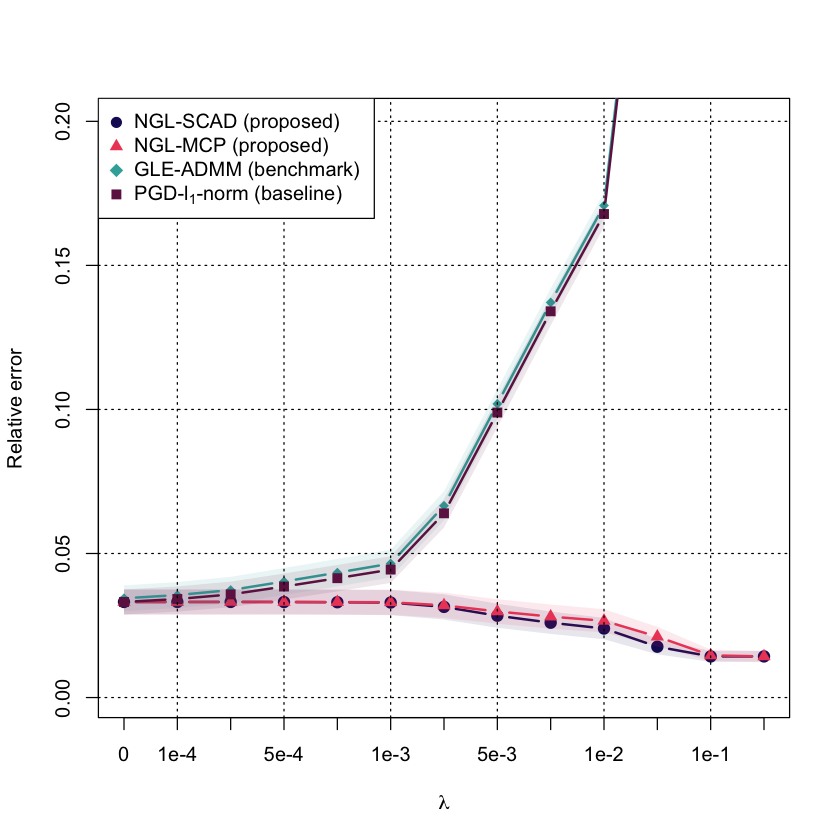

In [28]:
#setEPS()
#cairo_pdf("relative-error.pdf", family = "Palatino", height = 8,
#         width = 8, pointsize = 19)
plot(n_alphas, avg_re_scad, xlab = TeX("$\\lambda$"), ylab = "Relative error",
     type = "b", xaxt = "n", ylim = c(0.001, .2),
       pch=pch[1], lty=lty[1], cex=cex, col = colors[1], lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_re_scad - sd_re_scad, rev(avg_re_scad + sd_re_scad)),
        col = alpha(colors[1], alpha = .1), border = NA)
lines(n_alphas, avg_re_mcp, type = "b", pch=pch[2], lty=lty[2], cex=cex, col = colors[2], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_re_mcp - sd_re_mcp, rev(avg_re_mcp + sd_re_mcp)),
        col = alpha(colors[2], alpha = .1), border = NA)
lines(n_alphas, avg_re_admm, type = "b", pch=pch[3], lty=lty[3], cex=cex, col = colors[3], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_re_admm - sd_re_admm, rev(avg_re_admm + sd_re_admm)),
        col = alpha(colors[3], alpha = .1), border = NA)
lines(n_alphas, avg_re_pgd, type = "b", pch=pch[4], lty=lty[4], cex=cex, col = colors[4], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_re_pgd - sd_re_pgd, rev(avg_re_pgd + sd_re_pgd)),
        col = alpha(colors[4], alpha = .1), border = NA)
grid(col="black")
axis(side = 1, at = n_alphas, labels = labels)
legend("topleft", legend=legend, col=colors, pch=pch, bg="white", box.lty=1,
       pt.cex = c(1.1, 1.1, 1.5, 1.1))#, lty=lty)#, box.lty=1)#, )
#dev.off()

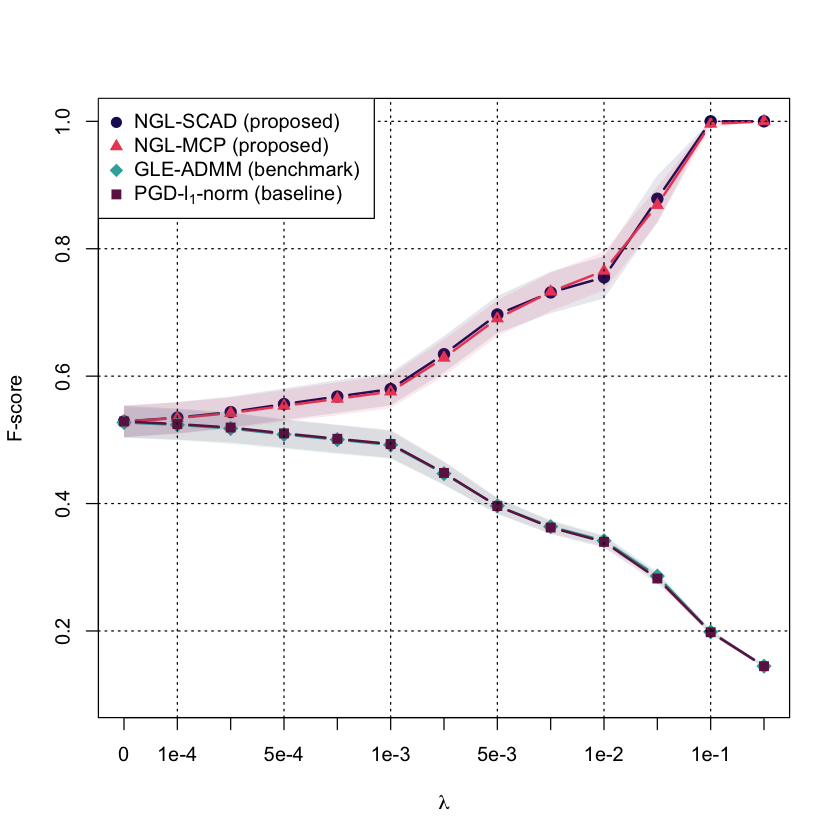

In [29]:
#setEPS()
#cairo_pdf("fscore.pdf", family = "Palatino", height = 8,
#         width = 8, pointsize = 19, fallback_resolution = 1400)
plot(n_alphas, avg_fs_scad, xlab = TeX("$\\lambda$"), ylim = c(.1, 1), ylab = "F-score", type = "b",
     pch=pch[1], lty=lty[1], cex=cex, col = colors[1], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_fs_scad - sd_fs_scad, rev(avg_fs_scad + sd_fs_scad)),
        col = alpha(colors[1], alpha = .1), border = NA)
lines(n_alphas, avg_fs_mcp, type = "b", pch=pch[2], lty=lty[2], cex=cex, col = colors[2], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_fs_mcp - sd_fs_mcp, rev(avg_fs_mcp + sd_fs_mcp)),
        col = alpha(colors[2], alpha = .1), border = NA)
lines(n_alphas, avg_fs_admm, type = "b", pch=pch[3], lty=lty[3], cex=1.7, col = colors[3], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_fs_admm - sd_fs_admm, rev(avg_fs_admm + sd_fs_admm)),
        col = alpha(colors[3], alpha = .1), border = NA)
lines(n_alphas, avg_fs_pgd, type = "b", pch=pch[4], lty=lty[4], cex=cex, col = colors[4], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_fs_pgd - sd_fs_pgd, rev(avg_fs_pgd + sd_fs_pgd)),
        col = alpha(colors[4], alpha = .1), border = NA)
grid(col="black")
axis(side = 1, at = n_alphas, labels = labels)
legend("topleft", legend=legend, col=colors, pch=pch, bg="white", box.lty=1,
       pt.cex = c(1.1, 1.1, 1.5, 1.1))#, lty=lty, bg="white", box.lty=0)
#dev.off()

In [30]:
yaxis <- c(49, 100, 200, 300, 400, 500)

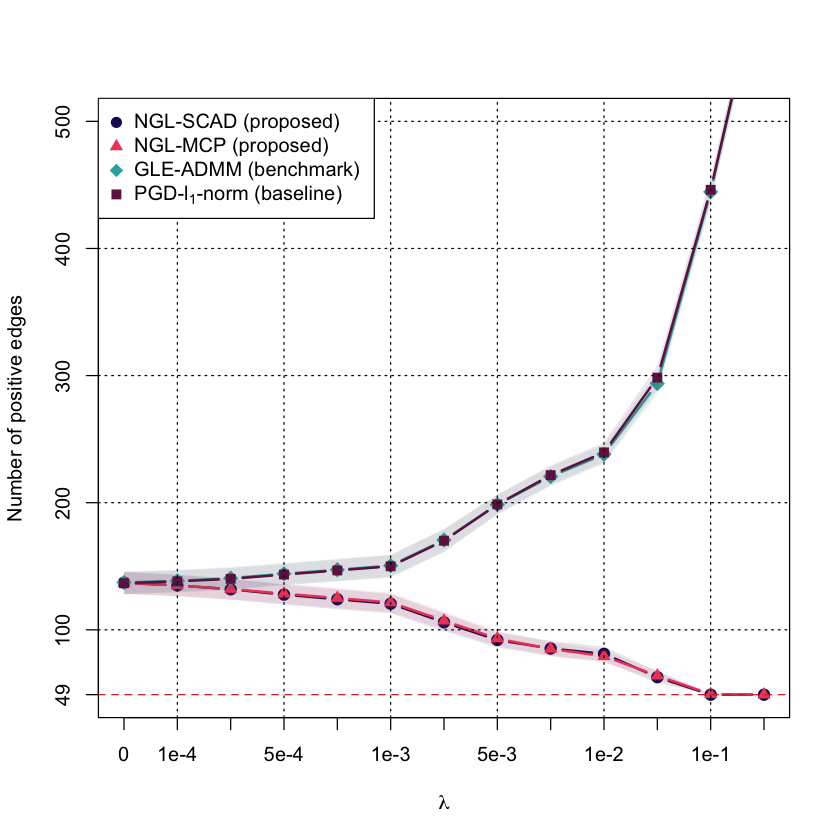

In [31]:
#setEPS()
#cairo_pdf("number-of-positive-edges.pdf", family = "Palatino", height = 8,
#         width = 8, pointsize = 19, fallback_resolution = 3000)
plot(n_alphas, avg_nonzero_edges_scad, xlab = TeX("$\\lambda$"), ylim = c(49, 500), ylab = "Number of positive edges", type = "b",
     pch=pch[1], lty=lty[1], cex=cex, col = colors[1], xaxt = "n", yaxt='n', lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_nonzero_edges_scad - sd_nonzero_edges_scad,
                                              rev(avg_nonzero_edges_scad + sd_nonzero_edges_scad)),
        col = alpha(colors[1], alpha = .1), border = NA)
lines(n_alphas, avg_nonzero_edges_mcp, type = "b", pch=pch[2], lty=lty[2], cex=cex, col = colors[2], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_nonzero_edges_mcp - sd_nonzero_edges_mcp,
                                              rev(avg_nonzero_edges_mcp + sd_nonzero_edges_mcp)),
        col = alpha(colors[2], alpha = .1), border = NA)
lines(n_alphas, avg_nonzero_edges_admm, type = "b", pch=pch[3], lty=lty[3], cex=1.7, col = colors[3], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_nonzero_edges_admm - sd_nonzero_edges_admm,
                                              rev(avg_nonzero_edges_admm + sd_nonzero_edges_admm)),
        col = alpha(colors[3], alpha = .1), border = NA)
lines(n_alphas, avg_nonzero_edges_pgd, type = "b", pch=pch[4], lty=lty[4], cex=cex, col = colors[4], xaxt = "n", lwd=lwd)
polygon(x = c(n_alphas, rev(n_alphas)), y = c(avg_nonzero_edges_pgd - sd_nonzero_edges_pgd,
                                              rev(avg_nonzero_edges_pgd + sd_nonzero_edges_pgd)),
        col = alpha(colors[4], alpha = .1), border = NA)
grid(col="black")
axis(side = 1, at = n_alphas, labels = labels)
axis(side = 2, at = yaxis, labels = yaxis)
abline(h=49, col="#d63031", lty=2)
legend("topleft", legend=legend, col=colors, pch=pch, bg="white", box.lty=1,
       pt.cex = c(1.1, 1.1, 1.5, 1.1))#, lty=lty, bg="white", box.lty=0)
#dev.off()